### ML Assignment 2: Oisin Brannock

The goal of this assignment is to make a machine learning algorithm from scratch. I chose to do this on the ID3 algorithm as we have covered this in the lectures and I understand the underlying concepts of the algorithm.

#### 1. Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize': (18, 7)}) # Sets plot aspect ratio
import random # Sets the seed used later and picks random rows for test_train_split
from pprint import pprint # Used to plot the tree
import itertools # Improve efficiency of code 
from IPython.display import Image # Input of my tree drawingf
import six
import sys
sys.modules['sklearn.externals.six'] = six
from id3 import Id3Estimator, export_graphviz, export_text # Import ID3 package used in assignment 1
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score # Only used for known method not my algorithm!
import pydot 

#### 2. Load and prep data

In [2]:
# List of columns names to input to df
names = ['calorific_value','nitrogen', 
         'turbidity', 'style', 'alcohol',
         'sugars', 'bitterness', 'beer_id', 
         'colour', 'degree_of_fermentation']

In [3]:
# Read in beer.txt as df using names above as our columns names
df = pd.read_table("C://Users/oisin/Documents/ML A2/beer.txt", 
                      names = names,
                      index_col = 'beer_id')

In [4]:
# Re-arrange the columns to have style at the end for ease
df = df[['calorific_value','nitrogen', 
                'turbidity', 'alcohol',
                'sugars', 'bitterness', 
                'colour', 'degree_of_fermentation', 
                'style']]

In [5]:
# Check out our dataset
df.head()

,calorific_value,nitrogen,turbidity,alcohol,sugars,bitterness,colour,degree_of_fermentation,style
beer_id,,,,,,,,,
93,41.721239,0.503276,2.628182,4.015385,16.73,10.452789,13.44,55.337143,ale
103,42.429204,0.525512,1.776364,4.092308,16.72,10.999526,12.24,58.380000,ale
178,45.880531,0.443233,2.628182,4.276923,16.68,13.456368,10.92,58.382857,ale
166,45.305310,0.471668,1.806364,4.126154,18.84,9.202737,10.92,58.525714,ale
44,38.977876,0.392846,2.272727,4.015385,16.77,9.457895,10.56,58.900000,ale


In [6]:
# Are there any nulls we need to evaluate in our dataset?
df.isnull().values.any()

False

Perfect! Can continue without having to do any more preprocessing. If there were nulls here depending on how many, I'd have removed them completely or taken the mean of the values and used that to populate the nulls

### 3. Designing the tree

#### 3.1 Train-Test Split Function

So if we have out df, we want to randomly select a certain number of rows which will be our test df. We want to randomly pick out a number from our index for df. Here we want 33% test and 67% train. So $154-(154*0.33)=51$ giving us our test data size for this dataset. I know the function then doesn't cater for proportions so I can add a statement to say if the number given to that argument is a float then multiply the float by the number of samples in the dataframe and round it to the nearest whole number! That way you can pass either a number of rows you want as the test size or a proportion.

How to design this function:

- Easiest thing I can think of is to get the index values, take a random sample of them equal to the test data size we want and return 2 new dataframes: test and train. Test will just be the index locations where the random samples are and the train dataset will be everything else. Easiest to keep it as close to sklearn as possible because that's what I know 
    

In [7]:
def test_train_split(df, test_size = 0.33):
    # Like I said above convert proportions to numeric based on df passed in
    if type(test_size) == float: 
        test_size = round(test_size * len(df))
    # Put the index values into a list
    index_values = list(df.index.values)
    # Pick out our random sample of test data from index_values
    test_index_values = random.sample(index_values, test_size)
    # Make a new dataframe test that contains the df values at the randomly selected indexes
    test = df.loc[test_index_values]
    # Make a new dataframe train that contains everything not used by test
    train = df.drop(test_index_values)
    
    # Pull back our two new dataframes
    return train, test

In [8]:
# Random seed is for when I need to compare with my earlier model from assignment 1 so results are consistent when rerun
random.seed(2) 
train, test = test_train_split(df)

In [9]:
# Test to see if the function worked properly based on the calculation I have performed above
print(len(train))
print(len(test))

103
51


Function performs as expected

In [10]:
# Finally I want to store my dataframe in df_array too to be able to use numpy methods on it when needed
df_array = df.values
df_array

array([[41.72123894, 0.503275756, 2.6281818180000003, ..., 13.44,
        55.33714286, 'ale'],
       [42.42920354, 0.52551218, 1.776363636, ..., 12.24, 58.38, 'ale'],
       [45.88053097, 0.443232788, 2.6281818180000003, ..., 10.92,
        58.38285714, 'ale'],
       ...,
       [43.97787611, 0.266770262, 3.775454545, ..., 7.32, 75.89428571,
        'stout'],
       [45.34955752, 0.255529552, 1.301818182, ..., 10.68, 76.18285714,
        'stout'],
       [41.19026549, 0.283402606, 2.620909091, ..., 8.04, 79.13428571,
        'stout']], dtype=object)

---------------------------------------------------------------------------------------------------------------------------------

#### 3.1: Classifier

What is the class of the beers? Is it ale lager or stout? This is the main function to be called later in our decision tree. It will be the decider overall.

In [11]:
def classifier(df_array):
    # Pick out the target variable - style
    target = df_array[:, -1] 
    # How many unique classes appear in the target column? How many of each are there? 
    classes, classes_n = np.unique(target, return_counts = True)
    # Which class occurs most often in the given array
    index = classes_n.argmax()
    # Convert the index gotten above into a class
    which_class_dominates = classes[index]
    
    return which_class_dominates

In [12]:
# Which class is most predominant in our training data?
classifier(df_array)

'lager'

---------------------------------------------------------------------------------------------------------------------------------

#### 3.2: All splits of the data

This function takes all the unique values from our feature columns, create a split down the middle between each consecutive point and return these splits into a dictionary where the keys are the column indexes and the values are all the splits that are possible for the points in that column.

In [13]:
def all_splits(df_array):
    potential_splits = {} # Initialize empty dict to store keys and values later
    # How many columns do we have? Shape tells us (rows,columns), and we only want columns so save that
    _ , n_columns = df_array.shape 
    # For each column we want to create an entry in our empty potential_splits dict
    for col_index in range(n_columns - 1): # -1 because we don't want our target column in there
        # Initialize an empty list to append the potential splits to
        potential_splits[col_index] = list()
        # The idea in ID3 is to get all the values between two points as the potential splits
        values = df_array[:, col_index]
        # We only need unique values from the column
        unique_values = np.unique(values)
        # Iterate over unique values array and take (n+1 + n) / 2 to get all the values that lie between the two points
        for i in range(len(unique_values)):
            if i != 0: # No value before 0th to add
                # v_k = value at k
                v_k = unique_values[i]
                # v_j = value at j (j = k - 1)
                v_j = unique_values[i - 1]
                # Get the midpoints between k and j
                potential_split = (v_k + v_j) / 2
                # append the split values to the value compnenent of our list
                potential_splits[col_index].append(potential_split)
                
    # Return now a dict with key as the column index and value as the list of midpoint values for that column
    return potential_splits

In [14]:
# Check to see if the function works
all_splits_vals = all_splits(train.values)

Text(0, 0.5, 'Calorific Value')

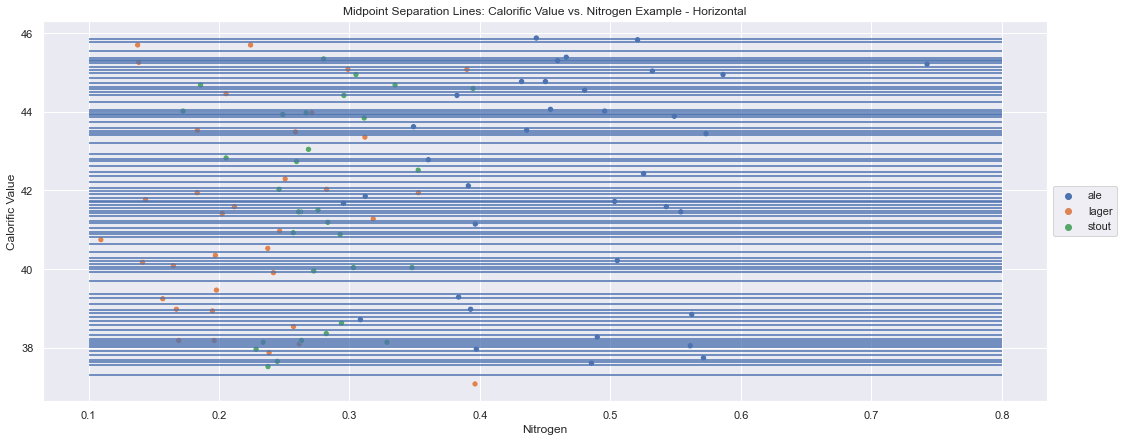

In [15]:
# We can visualise these midpoints by taking a simple scatter plot of two random columns and showing the overlay of the potential split
# Can do this in the x or y axis as splits for demonstration
# Note this isn't really relevant to the algorithm but I wanted to do it for my own understanding of the topic!
g = sns.scatterplot(data = train, x = "nitrogen", y = 'calorific_value', hue = 'style')
g.legend(loc='center left', bbox_to_anchor = (1, 0.5), ncol = 1)
#plt.vlines(x = potential_splits[1], ymin = 35, ymax = 50)
plt.hlines(y = all_splits_vals[0], xmin = 0.1, xmax = 0.8)
plt.title("Midpoint Separation Lines: Calorific Value vs. Nitrogen Example - Horizontal")
plt.xlabel("Nitrogen")
plt.ylabel("Calorific Value")

Text(0, 0.5, 'Calorific Value')

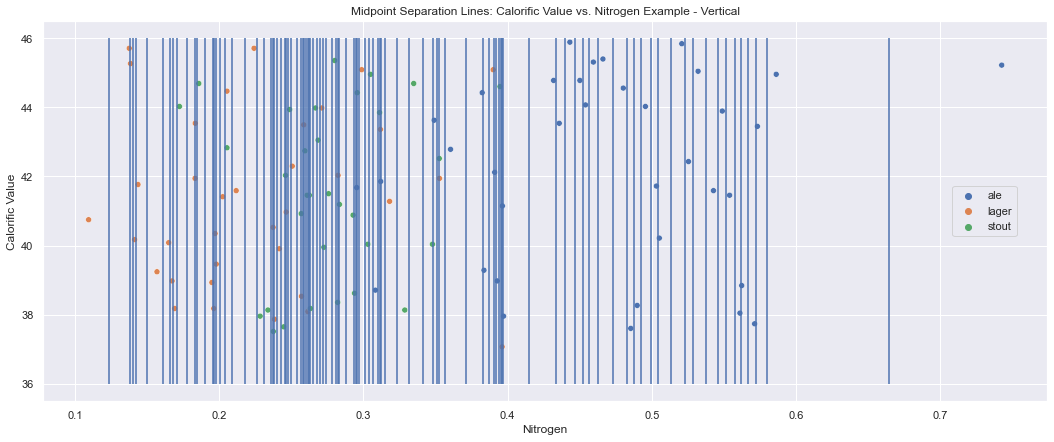

In [16]:
# Same as cell above but now with vertical splits
g = sns.scatterplot(data = train, x = "nitrogen", y = 'calorific_value', hue = 'style')
g.legend(loc='center left', bbox_to_anchor = (0.9, 0.5), ncol = 1)
plt.vlines(x = all_splits_vals[1], ymin = 36, ymax = 46)
#plt.hlines(y = potential_splits[0], xmin = 0, xmax = 1)
plt.title("Midpoint Separation Lines: Calorific Value vs. Nitrogen Example - Vertical")
plt.xlabel("Nitrogen")
plt.ylabel("Calorific Value")

Note above in both plots here how each line is the midpoint of the previous two lines. This is the basis of the best split function I define later down the line where we choose the style of beer based upon the splits

---------------------------------------------------------------------------------------------------------------------------------

#### 3.3: Entropy

In order to evaluate how the best splits will be chosen, the algorithm needs to be able to see the entropy values of the parameters passed in order to decide which has the lowest entropy and therefore highest information gain. Entropy is defined as:

$Ent(s) = \sum\limits_{i=1}^{n} -p_{i}log_{2}p_{i}$ 

$p_{i} =$ proportion of class $i$ in the dataset 

$i =$ each individual class present in the dataset. 

Here $i$ would be ale, lager and beer and the proportion of each would be the number of each in the dataset divided by the total number of classes in the dataset

So below my $s$ value is `df_array`. Again I only want to use numpy to do this as I'm working with a numpy array now.

In [17]:
def ent(df_array):
    # Take the target column - style
    target = df_array[:, -1]
    # np.unique pulls back all unique entries but I only want the counts
    _ , n = np.unique(target, return_counts = True)
    # As described above getting proportions as p_i
    p_i = n / n.sum()
    # Finally pull back the entropy of the dataset
    entropy = sum(-p_i * np.log2(p_i))
    
    return entropy

In [18]:
ent(df_array)

1.583247641378151

In a larger dataset it may be more efficient to define the entropy using list comprehensions

---------------------------------------------------------------------------------------------------------------------------------

#### 3.4: Split Data

Now I want to split my data into above and below certain thresholds. This is how the tree will interpret where to store certain things. The idea of splitting the data is that we split the data based on two factors: the split column and split value. Here they are simply hardcoded to show but the function can be used by taking the total entropy into accounnt!

In [19]:
def split_data(df_array, col, val):
    #  Take the column we wish to split on like we did with the 
    col_vals = df_array[:, col]
    # Simple split to make a new array with the values that don't meet the threshold set (are lower)
    n = df_array[col_vals <= val]
    # Simple split to make a new array with the values that don't meet the threshold set (are above)
    m = df_array[col_vals > val]
    
    return n, m

In [20]:
# Setting arbitrary values to test the functionality
col = 1
val = 0.5

In [21]:
n, m = split_data(df_array, col, val)

Text(0, 0.5, 'Calorific Value')

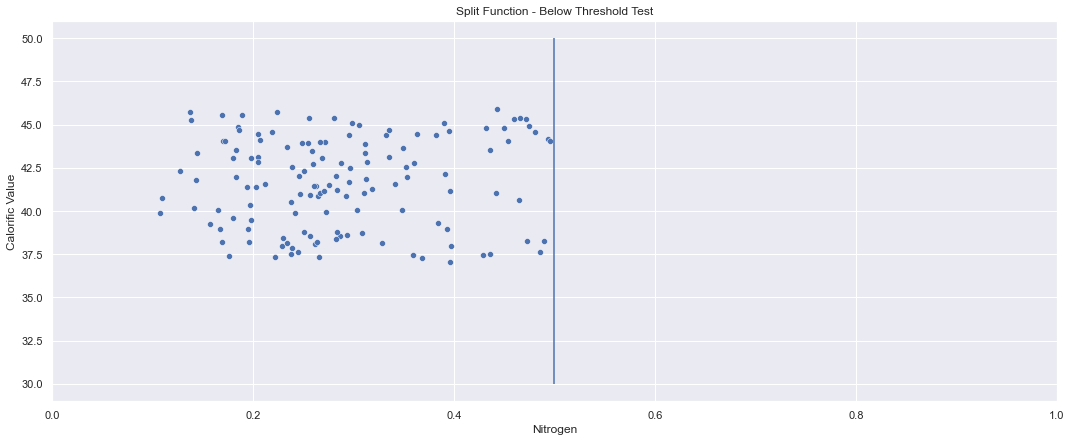

In [22]:
plotting_df_below = pd.DataFrame(n, columns = df.columns)
sns.scatterplot(data = plotting_df_below, x = "nitrogen", y = 'calorific_value')
plt.vlines(x = val, ymin = 30, ymax = 50)
plt.xlim(0, 1)
plt.title("Split Function - Below Threshold Test")
plt.xlabel("Nitrogen")
plt.ylabel("Calorific Value")

Text(0, 0.5, 'Calorific Value')

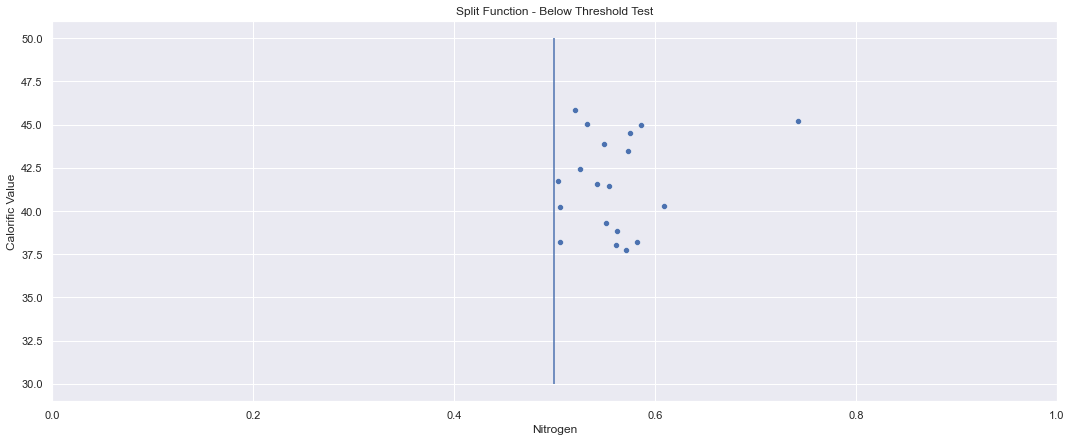

In [23]:
sns.set(rc={'figure.figsize':(18,7)})
# Conversion back to dataframe for plotting
plotting_df_above = pd.DataFrame(m, columns = df.columns)
sns.scatterplot(data = plotting_df_above, x =  "nitrogen", y = 'calorific_value')
plt.vlines(x = val, ymin = 30, ymax = 50)
plt.xlim(0, 1)
plt.title("Split Function - Below Threshold Test")
plt.xlabel("Nitrogen")
plt.ylabel("Calorific Value")

Works as expected

---------------------------------------------------------------------------------------------------------------------------------

#### 3.5: Total Entropy of dataframe

The total entropy of a dataframe is defined as:

$TE(s) = \sum\limits_{i = 1}^{n}p_{i}Ent(s)$

So basically instead of calculating the entropy for a single column like we did in the entropy function above, we need to generalise it so it works for the entire dataset. I'm going to define it using the splits as before but it could be defined without that. I'm simply doing it for consistency and cleanliness for the reader.

In [24]:
def df_entropy(n, m):
    # How many data points have we got overall between all points below and above our split value
    dp = len(n) + len(m)
    # Proportion of points below split
    p_n = len(n) / dp
    # Proportion of points above split
    p_m = len(m) / dp
    # Add the two entropy values together to get the total for the entire dataframe
    total_entropy = ((p_n * ent(n)) + (p_m * ent(m)))
    
    return total_entropy

In [25]:
df_entropy(n, m)

1.3640452890363013

#### 3.7: Deciding on the best split point\

Here we need to use the split function from before to say based on the lowest entropy values of that column, which point in there is the best one to split on that will give us the highest information gain. 

In [26]:
def best_split_decision(df_array, split):
    # This is struggled with for a week, but finally found that setting a really high value to set, we iterate until we get the best possible splits
    # For this data it only needs to be a value of 1 to work but setting it to say 10,000,000 will make it work for data with largers numerical values > 1
    arb_entropy = 10000000
    # For a column in all potential split columns (every feature column and not the target column)
    for col in split:
        # For all values of the splits across all features
        for val in split[col]:
            # define n and m using the split function defined before
            n, m = split_data(df_array, col = col, val = val)
            # Get the total entropy using df_entropy defined before
            calculated_entropy = df_entropy(n, m)
            # If the total entropy is less than or equal to the value defined at the start:
            if calculated_entropy <= arb_entropy:
                # Set the value at the start equal to our calculated entropy value
                arb_entropy = calculated_entropy
                # set the best split as the column with this lowest entropy value
                best_split_column = col
                # set the best split as the value from the column with this lowest entropy value
                best_split_value = val
                
    return best_split_column, best_split_value

In [27]:
# Does the function work as expected?
best_split_decision(df_array, all_splits_vals)

(1, 0.35662227049999995)

Works as expected

---------------------------------------------------------------------------------------------------------------------------------

#### 3.6: Purity


The final function I need to define is the purity of a given value. This is how the decision tree decides it can actually end the recursion otherwise it would go on forever. If a datapoint now only has one possible classification it can belong to, we return a simple boolean.

In [28]:
def single_class_check(df_array):
    # Get our target column - style
    target = df_array[:, -1]
    # Get all the possible classes in the column
    classes = np.unique(target)
    # If we have only one possible class value we return True else False. This is the basis for recursion
    if len(classes) == 1:
        return True
    else:
        return False

#### 4. Decision Tree Algorithm

The decision tree algorithm all comes together here. Encompassing all of the functions defined before, we take a dataframe (training data), set a type of counting argument to say when the recursion should stop (which is when a data point is pure and only has one possible classification as determined by the tree), and set a maximum number of recursions it should take 


In [29]:
# Needs to be defined in the global namespace as it doesn't work unless it is here.
col_labels = df.columns

In [30]:
def DT(df, a = 0, num_recursions = 4):
    
    # If our counting argument starts off with no runs of DT: We convert the df to a numpy array
    if a == 0:
        df_array = df.values
    # Else we just leave it alone because it has already been converted before to a numpy array
    else:
        df_array = df
    # Now we need to check if the data point in the array passed in is pure OR we have reached the max number of times we will go through recursion:
    if (single_class_check(df_array)) or (a == num_recursions):
        # We use the classifier function to classify that datapoint and return that as our class.
        target_class = classifier(df_array)
        return target_class
    # If the data is not pure or we are still within the max number of recursions:
    else:   
        # Append 1 to the recursion count
        a += 1
        # Get the splits dictionary using the potential split function
        all_splits_vals = all_splits(df_array)
        # Now get the single value that qualifies for the best split based on max information gain
        split_col, split_val = best_split_decision(df_array, all_splits_vals)
        # Split this into a lower and upper bound 
        n, m = split_data(df_array, split_col, split_val)
        # Put all the column labels into the dictionary
        cols = col_labels[split_col]
        # The key of our dictionary: e.g nitrogen <= 0.3345:
        decider = f"{cols} <= {split_val}"
        # The values of the key are our branches: These correspond to a simple yes or no
        branch = {decider: []}
        # Which class is it? 
        Y = DT(n, a, num_recursions)
        N = DT(m, a, num_recursions)
        # Append all answers back into our tree and show
        branch[decider].append(Y)
        branch[decider].append(N)
        
        return branch

In [31]:
# Does our tree run properly?
mytree = DT(train)
print(mytree)

{'bitterness <= 9.2874736845': [{'colour <= 11.1': ['stout', {'alcohol <= 4.1815384615': ['lager', 'stout']}]}, {'nitrogen <= 0.2889374695': [{'colour <= 7.56': ['stout', 'lager']}, {'sugars <= 16.34': ['lager', {'colour <= 15.54': ['ale', 'lager']}]}]}]}


What my tree looks like can be shown a bit better shown here:

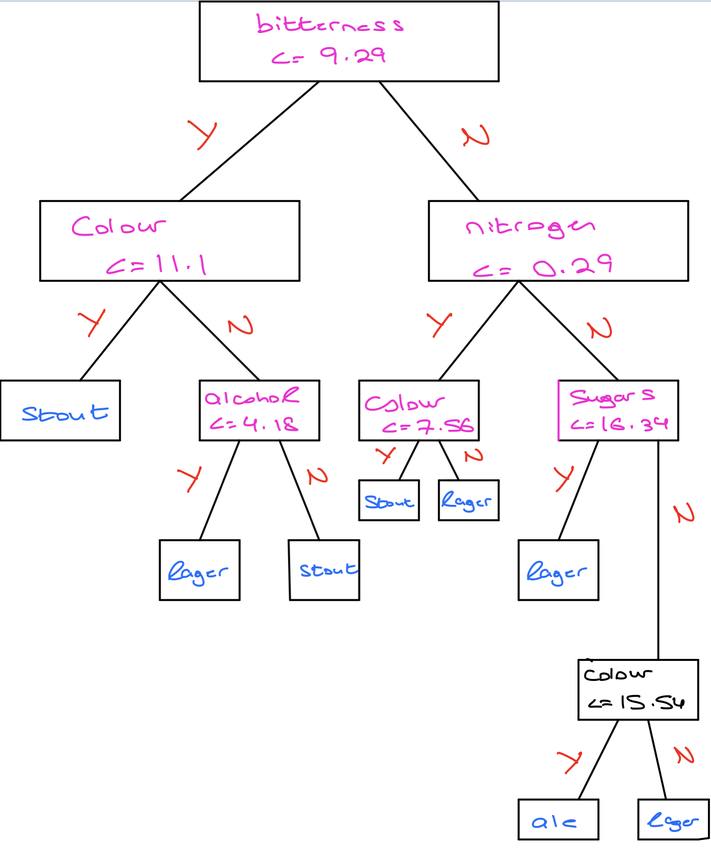

In [32]:
Image("C://Users/oisin/Documents/ML A2/ML A2 Plots/decisiontreeob.png")

#### 5.1 Classification

Now that we have a tree made we need to decide how to classify new unseen samples. For this I will take a random case and make a function to pass this value into. If they value of the attribute is less than the value of the tree branch then it can be classified accordingly. However I need to use recursion here again if not

In [33]:
# Taking a case now at random and showing all the values for it that are known to us but not the tree yet
case_rand = test.iloc[16]
case_rand

calorific_value            38.4469
nitrogen                  0.230199
turbidity                  2.30818
alcohol                    3.90769
sugars                       18.55
bitterness                 8.87789
colour                        9.36
degree_of_fermentation     65.4343
style                        stout
Name: 34, dtype: object

In [34]:
def classifier_test_cases(case, tree):
    branch = list(tree.keys())[0]
    cols, comparison_operator, vals = branch.split()

    if case[cols] <= float(vals):
        target_class = tree[branch][0]
    else:
        target_class = tree[branch][1]

    if type(target_class) !=  dict:
        return target_class
    else:
        new_branch = target_class
        return classifier_test_cases(case, new_branch)

In [35]:
# Does our sample get classified correctly? Yes!
classifier_test_cases(case_rand, mytree)

'stout'

#### 5.2 Accuracy

Now that I have a metric to classify a single example, I can apply this to the entire test dataset and create two new columns: `class_pred` which will be the predicted class made by the tree and `class_pred_bool` which returns a True if the class predicted matches the correct value and False otherwise. The good thing about Booleans is that I can get the mean of them as True = 1 and False = 0

In [36]:
def accuracy(df, tree):
    # Apply the classifier to the test df, args needs to have an empty second inner arg due to tuple generation
    df["class_pred"] = df.apply(classifier_test_cases, axis = 1, args = (tree, ))
    # True False splitting
    df["class_pred_bool"] = df['class_pred'] == df['style']
    # Round the accuracy and return the score for the test df supplied
    accuracy = round(df['class_pred_bool'].mean(), 2)
    
    return accuracy

In [37]:
accuracy(test, mytree)

0.9

In [38]:
accuracy(train, mytree)

1.0

In [39]:
test.head()

,calorific_value,nitrogen,turbidity,alcohol,sugars,bitterness,colour,degree_of_fermentation,style,class_pred,class_pred_bool
beer_id,,,,,,,,,,,
74,41.013274,0.441860,2.345455,4.264615,16.35,12.186053,12.12,63.747143,ale,ale,True
143,44.464602,0.363074,1.814545,4.147692,16.81,9.659053,12.48,67.898571,ale,ale,True
60,40.261062,0.609585,2.346364,4.421538,16.95,11.819000,10.32,67.557143,ale,ale,True
82,41.411504,0.194044,0.770000,3.510769,15.74,7.862579,13.20,68.728571,lager,lager,True
156,44.907080,0.475125,1.575455,4.049231,17.36,14.359789,12.36,73.432857,ale,ale,True


Now I need to do a confusion matrix and try and do a learning curve. I finally need to be able to do k-fold cross validation on the dataset

#### 5.3 Confusion Matrix

In [40]:
# Pandas has a crosstab function I can use to avoid sklearn!
y_actual = pd.Series(test['style'].values, name = 'Actual')
y_prediction = pd.Series(test['class_pred'].values, name = 'Predicted')
df_confusion = pd.crosstab(y_actual, y_prediction)

In [41]:
df_confusion

Predicted,ale,lager,stout
Actual,,,
ale,14,0,2
lager,0,16,3
stout,0,0,16


So we have 14 ales, 3 lagers and 16 stouts correctly classified

I can normalise it and show the proportions that were correct and incorrect too

In [42]:
df_conf_norm = df_confusion / df_confusion.sum(axis = 1)

In [43]:
df_conf_norm

Predicted,ale,lager,stout
Actual,,,
ale,0.875,0.000000,0.1250
lager,0.000,0.842105,0.1875
stout,0.000,0.000000,1.0000


**87.5%** of ales correct

**84.2%** of lagers correct

**100%** of stouts correct

#### 5.4 K-Fold Cross Validation

The idea here is to run the test_train_split function 10 times, and then get 10 different trees based on each one. Finally we can get the accuracy of each tree and get the average across all runs 

In [44]:
def k_fold_cv_1(df, test_size = 0.33):
    random.seed(2)
    # list comprehensions to get 10 new trees produced
    k_fold_splits = [test_train_split(df, test_size) for i in range(10)]
    # Split up the results into training and testing
    k_train_list = [x[0] for x in k_fold_splits]
    k_test_list = [x[1] for x in k_fold_splits]
    a = []
    # For a train df in the list, make a tree and append all trees to the empty list a
    for i in k_train_list:
        d = DT(i)
        a.append(d)
    l = []
    # for an entry in the trees and test list, run an accuracy on them and return a list of scores
    for i, j in itertools.product(a, k_test_list):
        acc = accuracy(j, i)
        l.append(acc)
    # Return every 10th score as the above runs 100 times as each i runs 10 times on each j
    scores = l[::10]
    # Return the scores list and then the average score
    return scores, f'Mean Score: {round((np.mean(scores)), 2)}'

In [45]:
k_fold_cv_1(df)

([0.9, 0.94, 0.96, 0.96, 0.94, 0.94, 1.0, 0.98, 0.96, 1.0], 'Mean Score: 0.96')

#### 5.5 Learning Curve

I can do a plot of `max_depth vs accuracy score` to see where to plot ends up levelling off

In [46]:
def learning_curve_my_algorithm(df, cases = 11):
    plt.figure(figsize=(20, 5))
    random.seed(2)
    train, test = test_train_split(df)
    l = []
    for case in range(cases):
        d = DT(test, num_recursions=case)
        l.append(d)
    # First result is a string not a dict because it only has one layer so remove it
    l = l[1:] 
    a = []
    for dtree in l:
        acc = accuracy(test, dtree)
        a.append(acc)
    plt.plot(np.linspace(1, 10, 10), a, 'g-')
    plt.axvline(x = 4, c = 'r', alpha = 0.35)
    plt.title("Learning Curve")
    plt.xlabel("Maximum Depth of my Decision Tree")
    plt.ylabel("Accuracy Score")
    plt.xticks(np.arange(1, 11, step = 1))

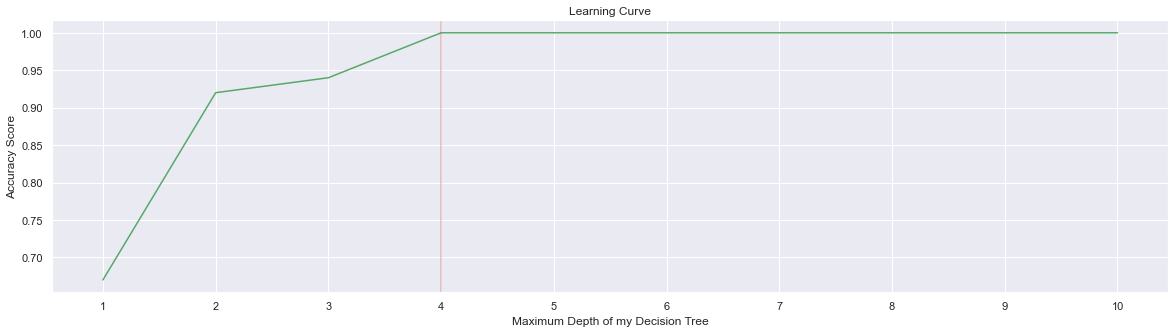

In [47]:
learning_curve_my_algorithm(df)

#### 6. Comparison of my algorithm vs ID3 used in assignment 1:

In [48]:
random.seed(2)
train, test = test_train_split(df)

In [49]:
test.columns

Index(['calorific_value', 'nitrogen', 'turbidity', 'alcohol', 'sugars',
       'bitterness', 'colour', 'degree_of_fermentation', 'style'],
      dtype='object')

In [50]:
X_train = train.drop('style', axis = 1)
X_train = X_train.to_numpy()

In [51]:
y_train = train['style']
y_train = y_train.to_numpy()

In [52]:
X_test = test.drop('style', axis = 1)
X_test = X_test.to_numpy()

In [53]:
y_test = test['style']
y_test = y_test.to_numpy()

In [54]:
clf = Id3Estimator(max_depth = 4)

In [55]:
clf.fit(X_train, y_train,check_input = True)

Id3Estimator(max_depth=4)

In [56]:
feature_cols = ['calorific_value','nitrogen', 
                'turbidity', 'alcohol',
                'sugars', 'bitterness', 
                'colour', 'degree_of_fermentation']

In [57]:
print(export_text(clf.tree_, feature_cols))


bitterness <=9.29
|   colour <=11.10: stout (30) 
|   colour >11.10
|   |   turbidity <=1.78: lager (17) 
|   |   turbidity >1.78: stout (1) 
bitterness >9.29
|   nitrogen <=0.29
|   |   turbidity <=2.84: lager (15) 
|   |   turbidity >2.84: stout (1) 
|   nitrogen >0.29
|   |   turbidity <=0.87: lager (2) 
|   |   turbidity >0.87
|   |   |   sugars <=16.34: lager (1) 
|   |   |   sugars >16.34: ale (36) 



In [58]:
dot_graph = export_graphviz(clf.tree_, "id3.dot", feature_cols)

In [59]:
(graph,) = pydot.graph_from_dot_file('id3.dot')
graph.write_png('id3.png')

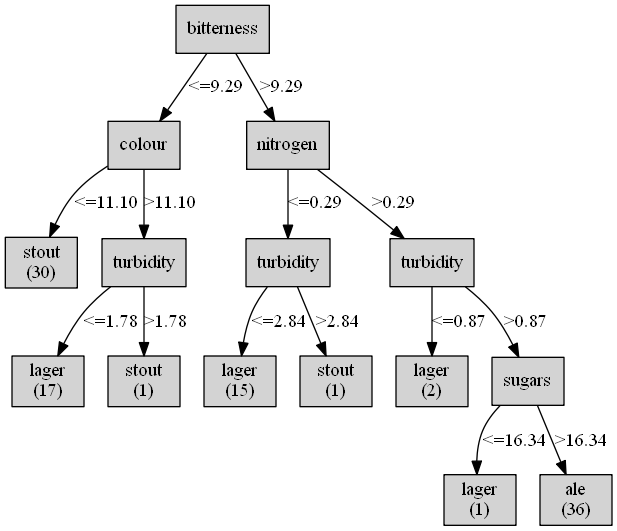

In [60]:
Image("C:/Users/oisin/Documents/ML A2/id3.png")

In [61]:
y_pred_train = clf.predict(X_train)

In [62]:
y_train_list = y_train.tolist()

In [63]:
y_pred_train_list = y_pred_train.tolist()

In [64]:
confusion_matrix(y_train_list, y_pred_train_list)

array([[36,  0,  0],
       [ 0, 35,  0],
       [ 0,  0, 32]], dtype=int64)

In [65]:
y_pred = clf.predict(X_test)

In [66]:
y_test_list = y_test.tolist()

In [67]:
y_pred_list = y_pred.tolist()

In [68]:
confusion_matrix(y_test_list, y_pred_list)

array([[14,  1,  1],
       [ 0, 15,  4],
       [ 0,  0, 16]], dtype=int64)

In [69]:
round(accuracy_score(y_test, y_pred), 2)

0.88

So here I can see that the training case is **100%** correct in the ID3 implementation package, while my algorithm also gets a **100%**. However on the test set the ID3 implementation package only receieves an **88%** while my algorithm scores an average of **96%** with the lowest score being **90%**.

Note that both of these algorithms perform to a `max_depth` of 4 to keep comparisons as fair as possible.

While a great result I have to consider that perhaps mine is focused a bit too much on this particular dataset and thats why the model works so well. Performing the same kind of analysis on a different dataset might yield a worse result.

Also something my algorithm cannot do directly is make a .dot file to produce a graphical version of the tree but time permitted it could all be done!